# Adding_SMOTE_to_the_grid_search_parameters

**Background:** Considering the imbalance isn't huge (~85:15), I want to add using over-sampling via SMOTE as a grid search parameter. 

**Purpose:** To add SMOTE as a grid search parameter

**Methods:**
>1. Introduction
>2. Inits

**Conclusions:**
* Using SMOTE improves the class 0 accuracy significantly
* Using SMOTE slightly worsens the test accuracy

# Inits

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook', font_scale=1.5)

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression

import mlflow

# Load my own custom module
import data_loading
import constants

import imblearn
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from plotnine import *

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Definitions

In [2]:
experiment_base_path = f'{constants.base_dir}/mlruns/'

test_param_dict = {'C': 1e-1,
             'max_iter': 100,
             'solver': 'saga',
             'class_weight': None,
             'lower_quantile_removed_CoV': 0}

## Funcs

### Running MLFlow with SMOTE as an optional method

In [3]:
def run_mlflow_exp_v8(curr_param_index, curr_params_dict):
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        Added the use of SMOTE as a hyperparameter
        """)
        
        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)

        # Split into CV/test set using target class to stratify
        X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        
        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []
        
        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]
            
            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Run SMOTE on the X,y data
            if curr_params_dict['use_smote']:
                smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                         random_state=110, 
                                                         k_neighbors=5, 
                                                         n_jobs=None)

                curr_fold_X_train, curr_fold_y_train = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

            # Train the model for this k-fold
            log_regr_clf.fit(curr_fold_X_train, curr_fold_y_train)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())
            
            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)
            
        
        # Run SMOTE on the full X_cv,y_cv data
        if curr_params_dict['use_smote']:
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)
            X_cv, y_cv = smote_obj.fit_sample(X_cv, y_cv)
        
        # Train the model
        log_regr_clf.fit(X_cv, y_cv)
        
        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        mlflow.log_param("use_smote", curr_params_dict['use_smote'])
        
        # Log accuracy metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

# Running with SMOTE as optional hyperparam

## Generate the results

In [4]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V8-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 5).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'use_smote': [True, False]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v8)(curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'V8-l1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

CPU times: user 1.06 s, sys: 580 ms, total: 1.64 s
Wall time: 24min 47s


In [29]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('V8-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v8_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

# Melt the dataframe to get accuracy as a single column
experiment_results_v8_df_melt = experiment_results_v8_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


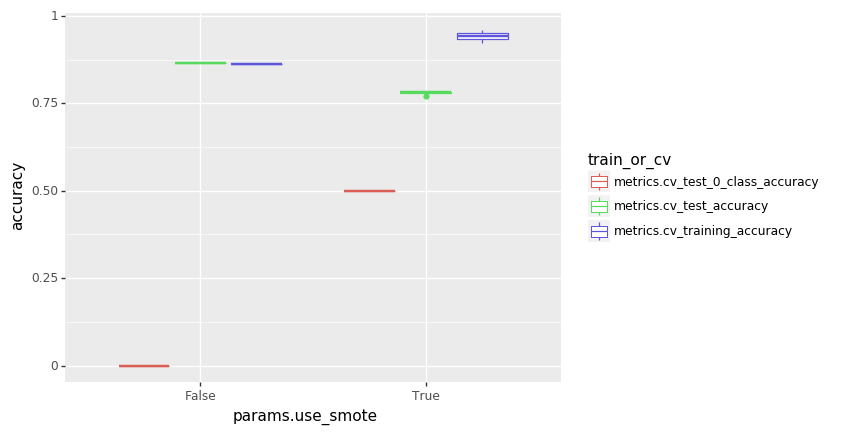

<ggplot: (8726192428121)>

In [47]:
plot_df = experiment_results_v8_df_melt\
    .loc[experiment_results_v8_df_melt['params.log10_C'] == "-1.0"]\
    .copy()

(ggplot(data=plot_df) 
 + geom_boxplot(aes(x='params.use_smote', 
                  y='accuracy', 
                  color='train_or_cv'))
)

* Using SMOTE improves the class 0 accuracy significantly
* Using SMOTE slightly worsens the test accuracy